In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
624,audio/fold7/110918-3-0-40.wav,110918,20.000000,24.000000,1,7,3,dog_bark
4079,audio/fold5/178686-0-0-21.wav,178686,10.500000,14.500000,2,5,0,air_conditioner
7930,audio/fold2/76086-4-0-53.wav,76086,26.500000,30.500000,1,2,4,drilling
5704,audio/fold4/22883-7-99-2.wav,22883,532.119811,536.119811,1,4,7,jackhammer
5591,audio/fold3/22601-8-0-12.wav,22601,6.000000,10.000000,2,3,8,siren


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
# define our global variables
learning_rate = 0.001
sound_dimension = [64, 256]
batch_size = 128
epoch = 20

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = matplotlib.mlab.specgram(data)[0]
    audio = scipy.misc.imresize(audio, sound_dimension)
    return audio.flatten()

In [6]:
class Model:
    def __init__(self, size_output):
        self.X = tf.placeholder(tf.float32, (None, sound_dimension[0] * sound_dimension[1]))
        self.Y = tf.placeholder(tf.float32, (None, size_output))
        
        w1 = tf.Variable(tf.random_normal([sound_dimension[0] * sound_dimension[1], 784], stddev = np.sqrt(1/784.0)))
        b1 = tf.Variable(tf.random_normal([784], stddev = 0))
        
        w2 = tf.Variable(tf.random_normal([784, 256], stddev = np.sqrt(1/256.0)))
        b2 = tf.Variable(tf.random_normal([256], stddev = 0))
        
        w3 = tf.Variable(tf.random_normal([256, 100], stddev = np.sqrt(1/100.0)))
        b3 = tf.Variable(tf.random_normal([100], stddev = 0))
        
        w4 = tf.Variable(tf.random_normal([100, size_output], stddev = np.sqrt(1/(size_output * 1.0))))
        b4 = tf.Variable(tf.random_normal([size_output], stddev = 0))
        
        hidden1 = tf.nn.relu(tf.matmul(self.X, w1) + b1)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
        self.logits = tf.matmul(hidden3, w4) + b4
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 20.043897319723058, 'avg acc: ', 0.33875019903536197, 'avg time: ', 1.101916238113686)
('epoch: ', 2, 'avg loss: ', 3.9210081939344055, 'avg acc: ', 0.45979938186981062, 'avg time: ', 1.0938507980770535)
('epoch: ', 3, 'avg loss: ', 2.4020709925227695, 'avg acc: ', 0.57135890755388474, 'avg time: ', 1.0940373517848827)
('epoch: ', 4, 'avg loss: ', 1.6694230922946223, 'avg acc: ', 0.63555111929222385, 'avg time: ', 1.0946411115151864)
('epoch: ', 5, 'avg loss: ', 1.4083303599445909, 'avg acc: ', 0.6986393100685544, 'avg time: ', 1.0940247420911435)
('epoch: ', 6, 'avg loss: ', 1.2402034920674783, 'avg acc: ', 0.71832755759910305, 'avg time: ', 1.094854054627595)
('epoch: ', 7, 'avg loss: ', 1.1842816118840818, 'avg acc: ', 0.72968760243168584, 'avg time: ', 1.09525379869673)
('epoch: ', 8, 'avg loss: ', 0.96113268865479362, 'avg acc: ', 0.77428424689504838, 'avg time: ', 1.0939563689408478)
('epoch: ', 9, 'avg loss: ', 0.95829410575054308, 'avg acc: ', 0.800

In [10]:
batch_x, batch_y, labels = [], [], []
for n in range(test_dataset.shape[0]):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.463215
                  precision    recall  f1-score   support

 air_conditioner       0.41      0.32      0.36       105
        car_horn       0.46      0.40      0.43        58
children_playing       0.33      0.12      0.17       126
        dog_bark       0.67      0.58      0.62       134
        drilling       0.42      0.72      0.53       137
   engine_idling       0.54      0.30      0.39       127
        gun_shot       0.60      0.59      0.60        59
      jackhammer       0.36      0.73      0.49       122
           siren       0.57      0.74      0.64       114
    street_music       0.31      0.13      0.19       119

     avg / total       0.46      0.46      0.44      1101



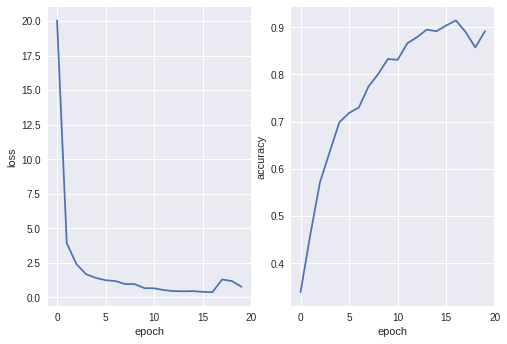

In [12]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()